In [24]:
palette = {
    'before-saline': 'orange',
    'after-saline': 'green',
    'before-drug': '#1F77B4',
    'after-drug': '#DA7F8C',
}

curations = {
    'D12_6': [9,10,11,14],
    'D13_4': [7,8,10,11,13],
    'D13_8': [14,23],
    'D14_6': [1,8,15,25,37],
}

In [25]:
# import anndata as ad 
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import scanpy 
# import scanpy.external as sce
# import seaborn as sns 
# import spikeinterface.core as sc 
# import spikeinterface.curation as scu
# import spikeinterface.extractors as se 
# import pandas as pd 
# from statannotations.Annotator import Annotator

# sampling_frequency = 30000
# n_ms_per_s = 1000
# n_frames_per_ms = sampling_frequency // n_ms_per_s
# ms_before = 2
# spike_index = n_frames_per_ms * ms_before
# n_s_per_min = 60
# n_file_compared = 4


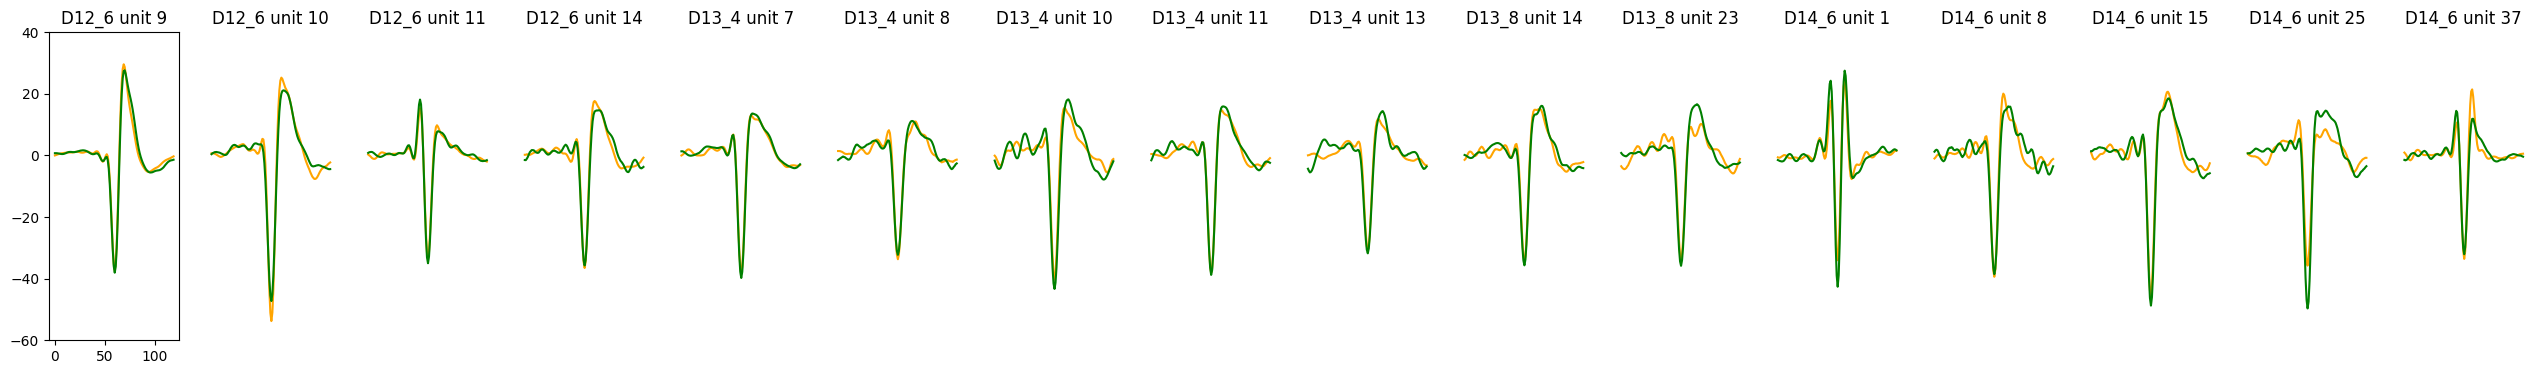

In [46]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os 
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se
from statannotations.Annotator import Annotator

figure_output_folder = 'data/processed/figures-2nd'
os.makedirs(figure_output_folder, exist_ok=True)    

sortdate = '240506'

ms_before = 2 
n_frames_per_ms = 30
spike_index = ms_before * n_frames_per_ms
n_s_per_min = 60
n_file = 8
n_file_per_condition = 4
threshold = 5.5
unit_index = 1
n_unit = sum([len(units) for units in curations.values()])


channel_indices = np.array([
    [ 0,  1,  2,  3,  7,  6,  5,  4],
    [ 8,  9, 10, 11, 15, 14, 13, 12],
    [16, 17, 18, 19, 23, 22, 21, 20],
    [24, 25, 26, 27, 31, 30, 29, 28],
    [32, 33, 34, 35, 39, 38, 37, 36],
    [40, 41, 42, 43, 47, 46, 45, 44],
    [48, 49, 50, 51, 55, 54, 53, 52],
    [56, 57, 58, 59, 63, 62, 61, 60],
    [64, 65, 66, 67, 71, 70, 69, 68],
    [72, 73, 74, 75, 79, 78, 77, 76],
])
def get_shank(channel_index):
    for shank, shank_index in enumerate(channel_indices):
        if channel_index in shank_index:
            return shank

waveforms_adatas = []
plt.figure(figsize=(n_unit*2, 4))
for subject, subject_units in curations.items():
    recordings = [sc.load_extractor(f'data/processed/{subject}/{sortdate}/recordings/file{file_index}') for file_index in range(n_file)]
    recording = sc.concatenate_recordings(recordings)
    
    sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{sortdate}/sortings-{threshold}/sorter_output/firings.npz')
    # spikeinterface https://github.com/SpikeInterface/spikeinterface/pull/1378
    sorting = scu.remove_excess_spikes(sorting, recording)
    sortings = sc.split_sorting(sorting, recordings)
    sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in 
    range(len(recordings))]

    waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/{sortdate}/waveforms-{threshold}/file{file_index}', with_recording=True, sorting=sortings[file_index]) for file_index in range(n_file)]

    for unit_id in subject_units:
        all_channel_waveforms = [waveform_extractor.get_waveforms(unit_id) for waveform_extractor in waveform_extractors]

        extremum_channels = [sc.get_template_extremum_channel(waveform_extractor, peak_sign='neg')[unit_id] for waveform_extractor in waveform_extractors]
        extremum_shanks = [get_shank(extremum_channel) for extremum_channel in extremum_channels]

        waveforms = [all_channel_waveform[:, :, extremum_channel] for extremum_channel, all_channel_waveform in zip(extremum_channels, all_channel_waveforms)]
        ax = plt.subplot(1, n_unit, unit_index)
        template_before = np.vstack(waveforms[:n_file_per_condition]).mean(0)
        template_after = np.vstack(waveforms[n_file_per_condition:]).mean(0)
        ax.plot(template_before, color=palette['before-saline'])
        ax.plot(template_after, color=palette['after-saline'])
        ax.set_title(f'{subject} unit {unit_id}')
        ax.set_ylim(-60, 40)
        if unit_index != 1: ax.set_axis_off()
        unit_index += 1

        shank_waveforms = [all_channel_waveform[:, :, channel_indices[extremum_shank]] for extremum_shank, all_channel_waveform in zip(extremum_shanks, all_channel_waveforms)]
        shank_waveforms_before = np.vstack(shank_waveforms[:n_file_per_condition])
        shank_waveforms_after = np.vstack(shank_waveforms[n_file_per_condition:])
        shank_waveforms_before = shank_waveforms_before.reshape(shank_waveforms_before.shape[0], -1)
        shank_waveforms_after = shank_waveforms_after.reshape(shank_waveforms_after.shape[0], -1)
        
        adata_before = ad.AnnData(X=shank_waveforms_before, obs={
            'subject': subject,
            'unit_id': unit_id,
            'condition': 'before-saline',
            'firing_rate': len(shank_waveforms_before) / n_s_per_min / n_file_per_condition,
            'trough': template_before[spike_index],
            'peak': template_before[spike_index:].max(),
        })
        
        adata_after = ad.AnnData(X=shank_waveforms_after, obs={
            'subject': subject,
            'unit_id': unit_id,
            'condition': 'after-saline',
            'firing_rate': len(shank_waveforms_after) / n_s_per_min / n_file_per_condition,
            'trough': template_after[spike_index],
            'peak': template_after[spike_index:].max(),
        })

        waveforms_adatas.append(adata_before)
        waveforms_adatas.append(adata_after)
        
waveforms_adata = ad.concat(waveforms_adatas, index_unique='#')
plt.show()
plt.clf()
plt.close('all')

    subject  unit_id      condition  firing_rate     trough       peak
0#0   D12_6        9  before-saline        3.325 -37.329423  29.605987
0#1   D12_6        9   after-saline        2.150 -38.047652  27.649650
    subject  unit_id      condition  firing_rate     trough       peak
0#2   D12_6       10  before-saline     0.316667 -53.759774  25.273761
0#3   D12_6       10   after-saline     0.354167 -47.262978  21.150248
    subject  unit_id      condition  firing_rate     trough      peak
0#4   D12_6       11  before-saline     0.500000 -33.530848  9.811021
0#5   D12_6       11   after-saline     0.416667 -34.987148  7.882952
    subject  unit_id      condition  firing_rate     trough       peak
0#6   D12_6       14  before-saline     0.333333 -36.528788  17.686319
0#7   D12_6       14   after-saline     0.141667 -35.714586  14.667267
    subject  unit_id      condition  firing_rate     trough       peak
0#8   D13_4        7  before-saline     0.550000 -38.241643  12.999940
0#9   D13

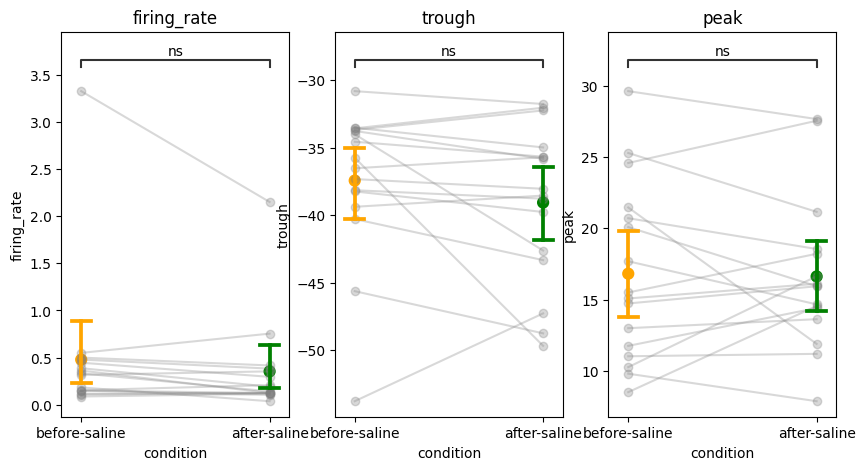

In [47]:
substance = 'saline'
stats = waveforms_adata.obs.drop_duplicates()

def draw_feature(feature, ax):
    def closure(grouped):
        ax.plot([0, 1], [grouped[grouped['condition'] == f'before-{substance}'][feature].item(), grouped[grouped['condition'] == f'after-{substance}'][feature].item()], marker='o', color='gray', alpha=0.3)
    return closure

features = ['firing_rate', 'trough', 'peak']
plt.figure(figsize=(10, 5))
for feature_index, feature in (enumerate(features)):
    ax = plt.subplot(1, len(features), feature_index+1, zorder=1)
    stats.groupby(['subject', 'unit_id']).apply(draw_feature(feature, ax))
    ax.set_title(feature)
    sns.pointplot(data=stats, x='condition', y=feature, order=[f'before-{substance}', f'after-{substance}'], ax=ax, capsize=0.1, palette=palette, zorder=10)
    annotator = Annotator(ax, [(f'before-{substance}', f'after-{substance}')], verbose=False, data=stats, x='condition', y=feature, order=[f'before-{substance}', f'after-{substance}'])
    annotator.configure(test="t-test_welch").apply_and_annotate()
    
plt.show()
plt.close()

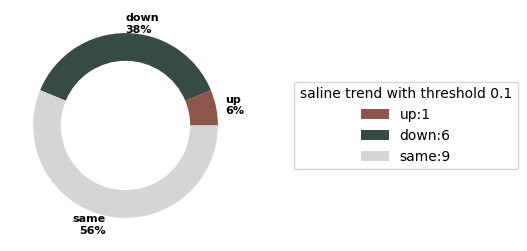

In [49]:
stats = waveforms_adata.obs.drop_duplicates()
unit_counts = {
    'up': 0,
    'down': 0,
    'same': 0,
}
no_change_threshold = 0.1
def count_unit(grouped):
    difference = abs(grouped[grouped['condition'] == f'after-{substance}']['firing_rate'].item() - grouped[grouped['condition'] == f'before-{substance}']['firing_rate'].item())
    if difference <= no_change_threshold:
        unit_counts['same'] += 1
    elif grouped[grouped['condition'] == f'after-{substance}']['firing_rate'].item() > grouped[grouped['condition'] == f'before-{substance}']['firing_rate'].item():
        unit_counts['up'] += 1
    else:
        unit_counts['down'] += 1
stats.groupby(['subject', 'unit_id']).apply(count_unit)


fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

counts = list(unit_counts.values())
trend_counts = [f'{k}:{v}' for k,v in unit_counts.items()]
trend_percents = [f'{k}\n{v/sum(unit_counts.values())*100:0.0f}%' for k,v in unit_counts.items()]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

wedges, autotexts = ax.pie(counts, labels=trend_percents,
                                wedgeprops=dict(width=0.3), colors=['#8C564B', '#374A46', '#d5d5d4'])

ax.legend(wedges, trend_counts,
        title=f'{substance} trend with threshold {no_change_threshold}',
        loc="center left",
        bbox_to_anchor=(1.2, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")
plt.show()